# Probability of Making 50% of Max Profit
In previous videos we modeled a stock's price action as a random walk.  The daily fraction change was given by,
\begin{equation}
\frac{S_{i+1} - S_i}{S_i} = r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i. 
\end{equation}
In the above equation, $S_i$ is the stock's price on the $i$th day,  $\Delta t$ is the time step-- in this case, one day-- $\sigma$ is the volatility and $r$ is the risk-free rate.  $\epsilon_1$ is a number sampled from the normal distribution and is how we generate the "random" part of the random walk.

If we can model a large number of potential scenarios, we can use the Black-Scholes model to calculate option behavior.  Recall the price of a call is given by,

$$C = \Phi(d_1) S - \Phi(d_2) K e^{-r t},$$
and the price of a put by,
$$P = \Phi(-d_2)e_{-rt} - \Phi(-d_1)S,$$
where
$$d_1 = \frac{1}{\sigma \sqrt{t}} \left[ \ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma.^2}{2}\right) t\right],$$
and
$$d_2 = d_1 - \sigma \sqrt{t}.$$

Now, knowing the price of our options for all the runs at all the times, we can  estimate various statistics.

![title](matrix_demo_final.png)

##  Imports

In [1]:
#  Imports
import numpy as np
import scipy
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

##  Define Functions

In [2]:
# Black-Scholes formulas for the prices of calls and putsthe the values of d1 and d2
#  S = stock price
#  K = strike price
#  r = risk-free rate (annualized)
#  t = time to expiration in years
#  sigma = implied volatility (annualized)
def call_price(d1, d2, S, K, r, t):
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C

def put_price(d1, d2, S, K, r, t):
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

def d(S, K, r, sigma, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    return d1, d2

#  Monte carlo simulation
def stock_monte_carlo(init_price, N_days, N_sims, dt, r, sigma, reshape = True):
    #  Scale interest rates and volatility to daily values
    r = r /252.0
    sigma = sigma / np.sqrt(252.0)
    
    #  Create a vector of nnormally distributed numbers.  This vector will be one below the main diagonal 
    #  The number of elements is therefore one less than the number of elements on the main diagonal.
    epsilon = np.random.normal(  size = (N_sims * N_days + N_sims - 1) )
    
    #  Use random numbers to generate daily percent change in stock prices
    ds_s = r * dt + sigma * np.sqrt(dt) * epsilon
    
    #  Create the vector of -1 that will be on the main diagonal
    ones = -np.ones( (N_sims * N_days + N_sims) )
    
    #  Starting with the first element, chage every N_days + 1 element to positive one.
    ones[0:-1:N_days+1] = 1
    
    #  Do a similar thing fot the other vector, changing its entry to -1
    ds_s[N_days:N_days * N_sims + N_sims:N_days+1] = -1
    d = [ds_s + 1, ones]
    K = [-1, 0]
    
    #  Create our sparse matrix
    M = scipy.sparse.diags(d, K, format = 'csc')
    
    #  This is our vector of knowns.  It is all zeros except for the elements that handle the initial (zeroth) dat.  In that case, it is the initial stock price.
    p = np.zeros( (N_sims * N_days + N_sims, 1) )
    p[0:-1:N_days+1] = init_price
    
    #  Solve the linear algebra problem
    s = scipy.sparse.linalg.spsolve(M, p)
    
    #  If reshape is set to true, reformat the output into a rectanglar matrix
    if reshape == True:
        s =  np.reshape(s, (N_sims, N_days+1))

    return s

        
        

##  Model stock prices and calculate option values

In [3]:
#  Define our parameters
#  S0 = initial stock price
#  K = strike price
#  r = risk-free rate
#  dt = time step
#  Sigma = implied volatility
S0 = 100.0

#  Strike prices
K_call= 105
K_put = 90

r = 0.02
dt = 1.0
sigma = 0.3
sigma_call = .3
sigma_put  = .30

#  Number of days until expiration and the total number of simulations to use in the model
N_days = 30
N_sims = 1000

#  Call our stock modeling code.  Returns a matrix (N_sims, N_days) in shape
S = stock_monte_carlo(S0, N_days, N_sims, dt, r, sigma, reshape = True)

#  Create a vector of days counting down from N_days to zero.  This need to be converted into years.  We are assuming trading days rather than calendar days
t_days = np.arange(N_days, -1, -1) / 252.0

#  Calculate d1, d2, and the call prices
d1, d2 = d(S, K_call, r, sigma_call, t_days)
C = call_price(d1, d2, S, K_call, r, t_days)

#  Put prices
d1, d2 = d(S, K_put, r, sigma_put, t_days)
P = put_price(d1, d2, S, K_put, r, t_days)

total_price = C + P

C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


##  Probability of making 50% on a single call option

The Black Scholes model gives the price of a long option.  Since I am assuming we are short the contract in this code, we want the value to drop below some threshold target before we close the position.

In [4]:
#  Get the initial call of the price on day zero.
init_price = C[0,0]

#  Search the matrix of prices checking which values are greater than the initial price (losers) or less than the inital price (winners).
losers = C[:, -1] >= init_price
winners = C[:, -1] <= init_price

#  Count the numbers of losers and winners.  Numpy treats False as zero and True as one for the purpose of summations
number_of_losers = sum(losers)
number_of_winners = sum(winners)
print('Probability of profit = ', number_of_winners / N_sims)

#  Extend this to probability of making 50% during the life of the trade
#  First find 50% of max profit
half_max = init_price / 2

#  Search the matrix of prices to see where our criterion is met.
reached_half_max = C <= half_max

#  Do a column-wise sum.  If we reached 50% during any time during the trade.  The sum will be at least one if not greater.
reached_half_max = np.sum(reached_half_max, axis = 1)

#  Calulcate the probability by summing the number of winners and dividing by the total number of simulations
prob = np.sum( reached_half_max > 0) / N_sims
print('Probability of making 50% = ', prob)

#  Plot the matrix of call prices to get a conceptual idea of what's going on
#or i in range(N_sims):
#   plt.plot(t_days * 252, C[i,:], alpha = 0.05)
#   
#lt.xlim([N_days, 0])
#lt.ylim([0, 25])
#lt.xlabel('Days To Expiration')
#lt.ylabel('Contract Price ($)')
#lt.grid(True)

Probability of profit =  0.765
Probability of making 50% =  0.86


##  Probability of making 50% on short strangle
### Extension of above to spreads

This can be extended to spreads by adding the prices of the options.  We then look for cases where the combined price drops below 50% of the sale price.


For positions where we are both long and short options, care needs to be taken about adding or subtracting prices.  For example, for a long call spread we would add the price of the long call and subtract the price of the short call.  Since we are long the spread, we want the value to rise so we’d look for cases where the final price was greater than the purchase price.

In [5]:
#  Get the initial price and calculate our 50% threshold.
init_price = total_price[0][0]
half_price = init_price / 2

#  Create a matrix with booleans if the cutoff has been reached
reached_half_max = total_price <= half_max

#  Do a column-wise sum.  If we reached 50% during any time during the trade.  The sum will be at least one if not greater.
reached_half_max = np.sum(reached_half_max, axis = 1)

#  Calulcate the probability by summing the number of winners and dividing by the total number of simulations
prob = np.sum( reached_half_max > 0) / N_sims
print('Probability of making 50% = ', prob)

Probability of making 50% =  0.747


##  AAPL Demo

C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


3.9892586213000385


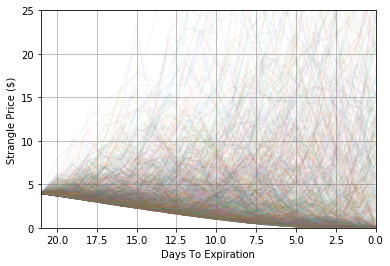

In [6]:
r = 0.01

K_put = 292.5
K_call = 350

sigma = 0.29
sigma_put = 0.297
sigma_call = 0.2886

S0 = 319

N_days = 21
N_sims = 1000
S = stock_monte_carlo(S0, N_days, N_sims, dt, r, sigma, reshape = True)

t_days = np.arange(N_days, -1, -1) / 252.0

d1, d2 = d(S, K_call, r, sigma_call, t_days)
C = call_price(d1, d2, S, K_call, r, t_days)

d1, d2 = d(S, K_put, r, sigma_put, t_days)
P = put_price(d1, d2, S, K_put, r, t_days)

total_price = C + P
print(total_price[0,0])

#  Plot the matrix of call prices to get a conceptual idea of what's going on
for i in range(N_sims):
   plt.plot(t_days * 252, total_price[i,:], alpha = 0.05)
   
plt.xlim([N_days, 0])
plt.ylim([0, 25])
plt.xlabel('Days To Expiration')
plt.ylabel('Strangle Price ($)')
plt.grid(True)
 

In [7]:
init_price = total_price[0][0]
half_price = init_price / 2

reached_half_max = total_price <= half_max

#  Do a column-wise sum.  If we reached 50% during any time during the trade.  The sum will be at least one if not greater.
reached_half_max = np.sum(reached_half_max, axis = 1)

#  Calulcate the probability by summing the number of winners and dividing by the total number of simulations
prob = np.sum( reached_half_max > 0) / N_sims
print('Probability of making 50% = ', prob)

Probability of making 50% =  0.812
